In [159]:
import copy
import numpy as np
import pandas as pd
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
#datacleaning()

# 读取数据
a=np.loadtxt('train_input.csv',dtype=np.float64)
b=np.loadtxt('output.txt',dtype=np.float64)
b = b[:,np.newaxis]
a[5] =(a[6]+a[5])/2
a = np.delete(a,6,axis=1)
#按行拼接，训练集输出也是信息
values=np.concatenate((a,b),axis=1)
#深复制而非浅复制，很有意思的
data = copy.deepcopy(values)
data = pd.DataFrame(data)
def series_to_supervised(data, n_in, n_out):
    df = pd.DataFrame(data)
    n_vars = df.shape[1]  # n_vars 列数
    cols, names = list(), list()
    
    # 时间间隔跨度, 时间点个数，共 n_in 个
    # 首先添加当前时刻之前的时间点
    for i in range(n_in - 1, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 然后添加当前时刻
    cols.append(df)
    names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]

    # 添加 target 为未来 n_out 分钟后时刻的温度
    cols.append(df.shift(-n_out))
    names += [('var%d(t+%d)' % (j + 1, n_out)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 删除缺失值
    agg.dropna(inplace=True)
    return agg
# 确保所有数据是 float64 类型
data = data.astype('float64')
# data

In [160]:
# 构建成监督学习数据集
# 比如根据当前时刻及之前100时刻的数据预测下一个时刻
# 这实际上是在获取 t - n_in + 1 时刻到 t 时刻共 n_in 个特征和第 t + n_out 时刻目标值
number1=30
number2=1

In [161]:
reframed = series_to_supervised(data, number1, number2)
reframed.head()
print(reframed.shape)
# reframed

(1566, 217)


In [162]:
#丢弃我们不想预测的列,这里预测的是最后一列，丢弃其他列
drop_col = [number1*7, number1*7+1, number1*7+2, number1*7+3, number1*7+4, number1*7+5]
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
# reframed.head()

In [163]:
# 把数据分为训练集和测试集
values = reframed.values
print(values.shape)

(1566, 211)


In [164]:
test = values[:int(values.shape[0]*0.2), :]
train = values[int(values.shape[0]*0.2):, :]

# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# 把输入重塑成符合LSTM输入的3D格式 [样例， 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], number1, 7))
test_X = test_X.reshape((test_X.shape[0], number1, 7))

print("训练集数据 shape:", train_X.shape)
print("训练集标签 shape:", train_y.shape)
print("测试集数据 shape:", test_X.shape)
print("测试集标签 shape:", test_y.shape)

训练集数据 shape: (1253, 30, 7)
训练集标签 shape: (1253,)
测试集数据 shape: (313, 30, 7)
测试集标签 shape: (313,)


In [165]:
epochs=50
batch_size = 32
learning_rate = 0.001
patience=3

In [166]:
import math
from keras.losses import mean_squared_error
from keras.callbacks import ReduceLROnPlateau
from keras.optimizer_v2.adam import Adam
from matplotlib import pyplot as plt
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.layers import Dropout, LSTM, Activation

# 搭建lstm网络模型，activation="RELU"
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.5))
# model.add(SimpleRNN(units=64, return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(32))
# 原本是model.add(Dense(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])
model.summary()


lrate = ReduceLROnPlateau(monitor= 'val_loss',min_lr=0.00001,patience=patience,factor=0.5)
# 拟合网络，batch_size默认32
history = model.fit(train_X,
                    train_y,
                    epochs = epochs,
                    batch_size=batch_size,
                    validation_data=(test_X, test_y),
                    callbacks=lrate,
                    verbose=1,
                    shuffle=True)
# 保存模型
model.save('results/LSTM_tiaocan.h5')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 30, 128)           69632     
_________________________________________________________________
activation_10 (Activation)   (None, 30, 128)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

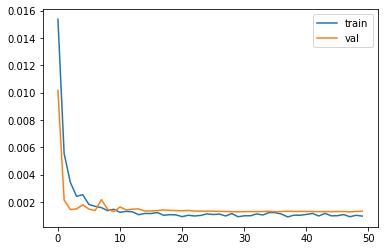

[0.001329778810031712, 0.0]


In [167]:
# 绘制历史数据
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
# 模型评估
score = model.evaluate(test_X, test_y, verbose=0)
print(score)
# 观察结果

In [168]:
from tensorflow.keras.models import load_model
# 加载模型调入测试集尝试一下
model_path = 'results/LSTM_tiaocan.h5'
model = load_model(model_path)

predicted_data = model.predict(test_X)
print(test_y.shape)
print(predicted_data.shape)
print(predicted_data[:,0].shape)
# predicted_data

(313,)
(313, 1)
(313,)


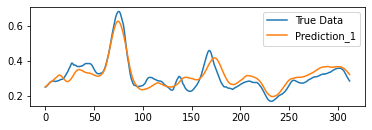

In [169]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(211)
ax.plot(test_y, label='True Data')
ax.plot(predicted_data[:,0], label='Prediction_1')
ax.legend()
plt.show()

In [170]:
pre_1_dim = predicted_data[:,0]

In [171]:
rmse = math.sqrt(mean_squared_error(test_y,pre_1_dim))
print("模型的RMSE:{}".format(round(rmse,3)))

模型的RMSE:0.036


In [172]:
# 读取数据输出结果
def predict(sequence):
    # 数据处理
    sequence = sequence.astype('float64')
    sequence = np.expand_dims(sequence, 0).repeat(1, axis=0)
    # print(sequence.shape)
    pre_t = model.predict(sequence)
    pre_t = np.float64(pre_t)
    return pre_t

a=np.loadtxt('train_input.csv',dtype=np.float64)
a[5] =(a[6]+a[5])/2
a = np.delete(a,6,axis=1)
b=np.loadtxt('output.txt',dtype=np.float64)
b = b[:,np.newaxis]

c=np.loadtxt('test_input.csv',dtype=np.float64)
c[5] = (c[5]+c[6])/2
c = np.delete(c,6,axis=1)
d=np.ones([798,1], dtype = np.float64)

values=np.concatenate((a,b),axis=1)
values2=np.concatenate((c,d),axis=1)
values = values[-number1:,:]
print(values.shape)
print(values2.shape)

(30, 7)
(798, 7)


In [173]:
for i in range(798):
    # print(predict(values))
    pre=predict(values)
    d[i] = pre
    # print(d[i])
    values = np.delete(values, 0, axis = 0)
    values2[i,6]=d[i]
    e = values2[i]
    e = e[np.newaxis,:]
    #print(e.shape)
    values=np.concatenate((values,e),axis=0)
    #print(values.shape)
data = pd.DataFrame(values2)
writer = pd.ExcelWriter('results/TESTLSTM.xlsx')
data.to_excel(writer, 'page_1', float_format='%.32f')		# ‘page_1’是写入excel的sheet名
writer.save()
writer.close()